In [53]:
from IPython.core.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<center><img src="birit-ka-ghorl.png"/></center>

<center><h1 style="color:#000000">A Study on Filipino's Love for Karaoke</h1></center>

In [54]:
# For data prep
import requests
import re
import numpy as np
import pandas as pd
import sqlite3
from sqlalchemy import create_engine


# For writeup
from textwrap import wrap
from IPython.display import HTML
from IPython.core.display import HTML as Center
import warnings
warnings.filterwarnings('ignore')

# For Information Retrieval
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from filipino_stopwords import fil_stop_words
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import nltk

#For dimensionality reduction
from sklearn.decomposition import PCA

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import datetime

# Custom plot format
plt.rcParams['figure.figsize'] = 16,6
plt.rcParams['lines.linewidth'] = 3.5
plt.rcParams['figure.titlesize'] = 32

custom_sns_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme('notebook', style='ticks', font_scale=1.5, rc=custom_sns_params)
colors = ['#393357', '#FFD400', '#00A5D3', '#009A57', '#6E3476']
colors_2 = ['#331a38', '#491d88', '#43b5a0', '#fec859', '#fa448c']
custom_palette = sns.blend_palette(colors_2, n_colors=5)
sns.set_palette(custom_palette)
custom_palette

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2023/byepes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(0.2, 0.10196078431372549, 0.2196078431372549),
 (0.2861822376009227, 0.11606305267204921, 0.5337024221453287),
 (0.2684967320261438, 0.7103883121876202, 0.6252672049211841),
 (0.9958938869665513, 0.7782237600922722, 0.35137254901960785),
 (0.9803921568627451, 0.26666666666666666, 0.5490196078431373)]

In [55]:
engine = create_engine('sqlite:////mnt/processed/private/msds2023/lt9/karaoke.db')
# engine = create_engine('sqlite:///karaoke.db')
df_videos = pd.read_sql_table('df_videos', engine)
df_views = pd.read_sql_table('df_views', engine)
df_comments = pd.read_sql_table('df_comments', engine)


<h1 style="color:#000000">I. Executive Summary</h1>

The art of vocal mimicry is a national pastime in the philippines.

It is an understatement to say that Filipinos love karaoke. Almost every Philippine home has a karaoke machine or a Magic Sing microphone – a digital mic that turns your television into a karaoke machine. It’s almost always a feature at birthday and holiday parties. And scores of bars and restaurants offer karaoke or videoke (a more competitive version that scores singers and records their performances).

This project aims to build a recommender engine that determines the top five song titles based on word query. The word query is the "tip of tongue" word that you use to describe the song as it is a usual occurence during karaoke sessions that you probably know the song, even the entirity of its lyrics, but you just can't seem to remember its title. 



<h1 style="color:#000000">II. Problem Statement</h1>

<center><img src="problem-statement-2.png"/></center>

<h1 style="color:#000000">III. Motivation</h1>

Tip of the tongue (also known as TOT or lethologica) is the phenomenon of failing to retrieve a word or term from memory, combined with partial recall and the feeling that retrieval is imminent.[1] The phenomenon's name comes from the saying, "It's on the tip of my tongue."[2][3][4]

This project aims to build a recommender engine that determines the top five song titles based on word query. It is a usual occurence during karaoke sessions that you probably know the song, even the entirity of its lyrics, but you just can't seem to remember its title. 

<h1 style="color:#000000">IV. Data Source</h1>

The study uses data from <b>Youtube API</b> to determine the top songs being searched and played on the channels listed below:


<center><img src="karaoke-channels.png"/></center>

<center><span style="font-size: 20px"><b>Youtube Data API v3</b></span></center>&nbsp; 
<center><img src="youtube-api.png"/></center>

<center><h3 style="color:#000000"><u>Raw Data Description</u></h3></center>

<span style="font-size: 16px">
    <center><b>Table 1. Karaoke Videos Raw Data Description</b></center>
</span>
    
|<center>Variable Name</center>|<center>Original Data type</center>|<center>Data type</center>|<center>Description</center>
|:---|:---|:---|:---|
|publishedAt|datetime|string|The date and time that the item was added to the playlist. The value is specified in ISO 8601 format.
|channelId|string|string|The ID that YouTube uses to uniquely identify the user that added the item to the playlist.
|title|string|string|The item's title.
|description|string|string|The item's description.
|channelTitle|string|string|The channel title of the channel that the playlist item belongs to.
|playlistId|string|string|The ID that YouTube uses to uniquely identify the playlist that the playlist item is in.
|position|unsigned integer|numpy.int64|The order in which the item appears in the playlist. The value uses a zero-based index, so the first item has a position of 0, the second item has a position of 1, and so forth.
|videoOwnerChannelTitle|string|string|The channel title of the channel that uploaded this video.
|videoOwnerChannelId|string|string|The channel ID of the channel that uploaded this video.
|kind|string|string|The kind, or type, of the referred resource.
|videoId|string|string|If the snippet.resourceId.kind property's value is youtube#video, then this property will be present and its value will contain the ID that YouTube uses to uniquely identify the video in the playlist.

<span style="font-size: 16px">
    <center><b>Table 2. Karaoke Video Statistics Raw Data Description</b></center>
</span>
    
|<center>Variable Name</center>|<center>Original Data type</center>|<center>Data type</center>|<center>Description</center>
|:---|:---|:---|:---|
|viewCount|unsigned long|string|The number of times the video has been viewed.
|likeCount|unsigned long|string|The number of users who have indicated that they liked the video.
|favoriteCount|unsigned long|string|Note: This property has been deprecated. The deprecation is effective as of August 28, 2015. The property's value is now always set to 0.
|commentCount|unsigned long|string|The number of comments for the video.
|videoId|string|string|The ID that YouTube uses to uniquely identify the video.


<span style="font-size: 16px">
    <center><b>Table 3. Karaoke Video Comments Raw Data Description</b></center>
</span>
    
|<center>Variable Name</center>|<center>Original Data type</center>|<center>Data type</center>|<center>Description</center>
|:---|:---|:---|:---|
|videoId|string|string|The ID of the video that the comment refers to. This property is only present if the comment was made on a video.
|textDisplay|string|string|The comment's text. The text can be retrieved in either plain text or HTML.
|textOriginal|string|string|The original, raw text of the comment as it was initially posted or last updated. The original text is only returned if it is accessible to the authenticated user, which is only guaranteed if the user is the comment's author.
|authorDisplayName|string|string|The display name of the user who posted the comment.
|authorProfileImageUrl|string|string|The URL for the avatar of the user who posted the comment.
|authorChannelUrl|string|string|The URL of the comment author's YouTube channel, if available.
|canRate|boolean|numpy.int64|This setting indicates whether the current viewer can rate the comment.
|viewerRating|string|string|The rating the viewer has given to this comment. Note that this property does not currently identify dislike ratings, though this behavior is subject to change. In the meantime, the property value is like if the viewer has rated the comment positively. The value is none in all other cases, including the user having given the comment a negative rating or not having rated the comment.
|likeCount|unsigned integer|numpy.int64|The total number of likes (positive ratings) the comment has received.
|publishedAt|datetime|string|The date and time when the comment was orignally published. The value is specified in ISO 8601 format.
|updatedAt|datetime|string|The date and time when the comment was last updated. The value is specified in ISO 8601 format.
|value|string|object|The ID of the comment author's YouTube channel, if available.
|moderationStatus|string|object|The comment's moderation status. This property is only returned if the API request was authorized by the owner of the channel or the video on which the requested comments were made. In addition, note that this property is not set if the API request used the id filter parameter.

<center><h3 style="color:#000000"><u>Final Data Description</u></h3></center>

<span style="font-size: 16px">
    <center><b>Table 4. Karaoke Videos Data Description</b></center>
</span>
    
|<center>Variable Name</center>|<center>Original Data type</center>|<center>Data type</center>|<center>Description</center>
|:---|:---|:---|:---|
|publishedAt|datetime|datetime64|The date and time that the item was added to the playlist. The value is specified in ISO 8601 format.
|channelId|string|string|The ID that YouTube uses to uniquely identify the user that added the item to the playlist.
|title|string|string|The item's title.
|description|string|string|The item's description.
|channelTitle|string|string|The channel title of the channel that the playlist item belongs to.
|playlistId|string|string|The ID that YouTube uses to uniquely identify the playlist that the playlist item is in.
|videoId|string|string|If the snippet.resourceId.kind property's value is youtube#video, then this property will be present and its value will contain the ID that YouTube uses to uniquely identify the video in the playlist.
|song_title|string|string|The song title of the item, feauture engineered from the title column using regex.
|artist|string|string|The song artist of the item, feauture engineered from the title column using regex.
|viewCount|unsigned long|int64|The number of times the video has been viewed.
|likeCount|unsigned long|int64|The number of users who have indicated that they liked the video.
|commentCount|unsigned long|int64|The number of comments for the video.

<span style="font-size: 16px">
    <center><b>Table 5. Karaoke Video Comments Data Description</b></center>
</span>
    
|<center>Variable Name</center>|<center>Original Data type</center>|<center>Data type</center>|<center>Description</center>
|:---|:---|:---|:---|
|videoId|string|string|The ID of the video that the comment refers to. This property is only present if the comment was made on a video.
|textOriginal|string|string|The original, raw text of the comment as it was initially posted or last updated. The original text is only returned if it is accessible to the authenticated user, which is only guaranteed if the user is the comment's author.
|authorDisplayName|string|string|The display name of the user who posted the comment.
|authorProfileImageUrl|string|string|The URL for the avatar of the user who posted the comment.
|authorChannelUrl|string|string|The URL of the comment author's YouTube channel, if available.
|likeCount|unsigned integer|numpy.int64|The total number of likes (positive ratings) the comment has received.
|publishedAt|datetime|datetime64|The date and time when the comment was orignally published. The value is specified in ISO 8601 format.
|updatedAt|datetime|datetime64|The date and time when the comment was last updated. The value is specified in ISO 8601 format.

<h1 style="color:#000000">V. Data Exploration</h1>

<span style="font-size: 14px">
    This section contains the Exploratory Data Analysis (EDA) portion of study. This section aims to discover patterns, spot anomalies, test hypothesis, and check assumptions with the help of graphical representations.
</span>

In [56]:
# CoversPH
df_videos.iat[356, 2] = 'SOMEWHERE OVER THE RAINBOW - Connie Talbot/MALE KEY (KARAOKE PIANO VERSION)'
df_videos.iat[426, 2] = 'PANALO - Ez Mil (KARAOKE VERSION)'
df_videos.iat[541, 2] = 'YOU - The Carpenters/MALE KEY (KARAOKE VERSION)'
df_videos.iat[567, 2] = 'KABILANG BUHAY - Bandang Lapis/FEMALE KEY (KARAOKE VERSION)'
df_videos.iat[664, 2] = 'DALAGA - Arvey (CoversPH KARAOKE VERSION)'
df_videos.iat[666, 2] = 'A MILLION DREAMS - The Greatest Showman (CoversPH KARAOKE VERSION)'
df_videos.iat[712, 2] = 'AKING PAGMAMAHAL - Chloe Anjeleigh (KARAOKE VERSION)'
df_videos.iat[713, 2] = 'DDU DU DDU DU - Ysabelle Cuevas & Emma Heesters (KARAOKE VERSION)'
df_videos.iat[714, 2] = 'SIOMAI RICE - $UCC (KARAOKE VERSION) #ANGPINAKAMAKABULUHANGKANTANGTAON'
df_videos.iat[732, 2] = 'BUWAN - Juan Karlos Labajo/FEMALE KEY (KARAOKE VERSION)'
df_videos.iat[807, 2] = 'I CAN - Janella Salvador (KARAOKE VERSION)'
df_videos.iat[875, 2] = 'MAHAL KITA PERO - Janella Salvador (KARAOKE VERSION)'
df_videos.iat[880, 2] = 'Noege - Yohan Hwang (KARAOKE VERSION)'
df_videos.iat[910, 2] = 'CASTLE ON THE HILL - Ed Sheeran (KARAOKE VERSION)'
df_videos.iat[911, 2] = 'You Are My World - YOON MI RAE (KARAOKE VERSION)'
df_videos.iat[941, 2] = 'THE GREAT UNKNOWN - Sarah Geronimo ft. Hale (KARAOKE VERSION)'
df_videos.iat[951, 2] = 'TILL I MET YOU - JADINE (KARAOKE VERSION)'
df_videos.iat[984, 2] = 'TULOY PA RIN - Krystle Yague & Dan Billano (KARAOKE VERSION)'

# Pinoy Videoke Tambayan
df_videos.iat[1028, 2] = 'Listen - KARAOKE VERSION - in the style of Beyoncé'
df_videos.iat[1104, 2] = 'Ipagpatawad Mo - KARAOKE VERSION - as popularized by VST and CO.'
df_videos.iat[1217, 2] = 'Imagine - KARAOKE VERSION - as popularized by John Lennon'
df_videos.iat[1247, 2] = 'Leader Of The Band - KARAOKE VERSION - as popularized by Dan Fogelberg'
df_videos.iat[1313, 2] = 'Where Do Broken Hearts Go - KARAOKE VERSION - As popularized by Whitney Houston'

df_videos.iat[1546, 2] = "I Don't Know Why You Love Me - Cotton, Lloyd & Christian (KARAOKE VERSION)"
df_videos.iat[1552, 2] = "Our Love (Don't Throw It All Away) - Andy Gibb (KARAOKE VERSION)"
df_videos.iat[1577, 2] = 'I Was Looking For Someone To Love - Leif Garrett (KARAOKE VERSION)'
df_videos.iat[1580, 2] = 'Where Do I Go From Here - England Dan & John Ford Coley (KARAOKE VERSION)'
df_videos.iat[1595, 2] = 'Touch and Go - Rupert Holmes (KARAOKE VERSION)'
df_videos.iat[1598, 2] = "Let's Stop Before We Fall In Love - Norman Saleet (KARAOKE VERSION)"
df_videos.iat[1600, 2] = 'Ngayon at Kailanman - Basil Valdez (KARAOKE VERSION)'
df_videos.iat[1602, 2] = 'We All Fall In Love Sometimes - Elton John (KARAOKE VERSION)'
df_videos.iat[1603, 2] = 'Maybe this Time - Michael Martin Murphey (KARAOKE VERSION)'
df_videos.iat[1604, 2] = 'What Kind of Fool Am I - Regine Velasquez (KARAOKE VERSION)'
df_videos.iat[1605, 2] = "This Time I Know It's Real - Norman Saleet (KARAOKE VERSION)"
df_videos.iat[1608, 2] = 'My Fair Share - Seals & Crofts (KARAOKE VERSION)'
df_videos.iat[1609, 2] = "Don't Give Up On Us - David Soul (KARAOKE VERSION)"
df_videos.iat[1611, 2] = 'Broken Hearted Me - Anne Murray (KARAOKE VERSION)'
df_videos.iat[1612, 2] = 'Lumayo Ka Man sa Akin - Rodel Naval (KARAOKE VERSION)'
df_videos.iat[1613, 2] = 'Lost - Michael Buble (KARAOKE VERSION)'

df_videos.iat[1373, 2] = "If You're Not Here (By My Side) - Menudo (KARAOKE VERSION)"
df_videos.iat[1639, 2] = 'Starting Over Again - Kath Loria (KARAOKE)'
df_videos.iat[1640, 2] = 'Tulad mo - TJ Monterde (KARAOKE)'
df_videos.iat[1642, 2] = 'Torete - Moira Dela Torre (KARAOKE)'
df_videos.iat[1643, 2] = "I'll Never Love This Way Again - JONA (KARAOKE)"
df_videos.iat[1644, 2] = 'The Way You Look At Me - Christian Bautista (KARAOKE)'
df_videos.iat[1646, 2] = 'Pangako - Kindred Garden (KARAOKE)'
df_videos.iat[1647, 2] = 'Pusong Ligaw - JONA (KARAOKE)'
df_videos.iat[1648, 2] = 'Bakit Ba - Siakol (KARAOKE)'
df_videos.iat[1649, 2] = 'Secret Love Song - Morissette Amon (KARAOKE)'
df_videos.iat[1650, 2] = 'Against All Odds - Morissette Amon (KARAOKE)'
df_videos.iat[1706, 2] = 'I Believe - Jimmy Bondoc (KARAOKE)'

# Karaoke Negra
df_videos.iat[1645, 2] = 'Huwag Na Lang Kaya - True Faith(KARAOKE)'
df_videos.iat[1653, 2] = 'Paano Ba Ang Magmahal - Sarah Geronimo ft. Piolo Pascual (KARAOKE)'
df_videos.iat[1658, 2] = 'Dahil Sayo - Inigo Pascual (KARAOKE)'
df_videos.iat[1658, 2] = 'Bilog Na Naman Ang Buwan – Tropical Depression (KARAOKE)'
df_videos.iat[1730, 2] = 'Pusong Ligaw - Jericho Rosales (with Melody)'
df_videos.iat[1737, 2] = 'Esem - Yano (KARAOKE) HD'


# AcousticHeaven
df_videos.iat[1808, 2] = 'Arthur Miguel/Taylor Swift - Crazier (Acoustic/Karaoke) [Female Key]'
df_videos.iat[1915, 2] = "Rivermaya - You'll Be Safe Here (Karaoke/Acoustic Instrumental)"
df_videos.iat[2018, 2] = 'I Belong To The Zoo - Balang Araw (Karaoke /Acoustic Instrumental) [Female Key]'
df_videos.iat[2142, 2] = "First Circle - Ako'y Sayo At ika'y akin lamang (Karaoke/Acoustic Instrumental)"
df_videos.iat[2147, 2] = "Rey Valera - Maging Sino Ka man (Karaoke/Acoustic)"
df_videos.iat[2155, 2] = "Up DharmaDown - Tadhana (Karaoke)"
df_videos.iat[2159, 2] = "Siakol - Bakit ba (Karaoke/Instrumental)"

# KaraoKeysPH
df_videos.iat[2328, 2] = 'Ikaw Ay Ako - Morisette Amon & Klarisse De Guzman (Piano Karaoke)'
df_videos.iat[2687, 2] = 'Still Together - Bright Vachirawit & Win Metawin (Female Key - Karaoke)'
df_videos.iat[2688, 2] = 'Still Together - Bright Vachirawit & Win Metawin (Piano Karaoke)'
df_videos.iat[2709, 2] = 'Yellow - Coldplay/Katherine Ho (Male Key - Piano Karaoke)'
df_videos.iat[2710, 2] = 'Yellow - Coldplay/Katherine Ho (Piano Karaoke)'
df_videos.iat[2758, 2] = 'Climax - Usher (Short Piano Karaoke)'
# df_videos = df_videos.drop([927, 1584, 1618, 1764, 1790, 1805, 2683])
#drop 1763, 581


In [57]:
# Extracting Title and Artist
df_videos = df_videos.drop_duplicates()
df_reg = df_videos['title'].str.extract(r'([\w\d\s\(\)\[\]\'\/\.\!\?\*\:]+)[❤️\s]*[\–\-]\s(?:by\s)*(?:Cover by\s)*([\w\d\s\$\.\'\&]+)[🌷\s]*')
df_reg.columns = ['song_title', 'artist']
df_videos[['song_title', 'artist']] = df_reg

# Swap title and artist column for AcousticHeaven
df_ah = df_videos.loc[df_videos['channelTitle'] == 'AcousticHeaven']
df_ah = df_ah.iloc[:,-2:]
df_videos.loc[df_videos['channelTitle'] == 'AcousticHeaven', ['song_title', 'artist']] = df_ah[['artist', 'song_title']].values

# Drop unnecessary columns
df_videos = df_videos.drop([581, 927, 946, 1584, 1618, 1763, 1764, 1790, 1805, 2683])
df_videos['song_title'] = df_videos['song_title'].str.strip()
df_videos['artist'] = df_videos['artist'].str.strip()

# Further fix song_title and artist column
df_karver = df_videos.loc[df_videos['artist'] == 'KARAOKE VERSION']
df_kareg = df_karver['title'].str.extract(r'([\w\d\s\(\)\[\]\'\?\!]+)\s+[\–\-]\s+[\S\s]*\s+[\–\-]\s+(?:by )*(?:in the style of )*(?:as popularized by )*(?:As popularized by )*([\w\d\s\(\)\[\]\'\&\.]+)')
df_videos.loc[df_videos['artist'] == 'KARAOKE VERSION', ['song_title', 'artist']] = df_kareg.values

# Cleaning df_videos
df_videos = df_videos.drop(['position', 'videoOwnerChannelTitle', 'videoOwnerChannelId', 'kind'], axis=1)

# Cleaning df_views
df_views.loc[df_views['likeCount'].isna() == True, 'likeCount'] = 0
df_views.loc[df_views['commentCount'].isna() == True, 'commentCount'] = 0
df_views = df_views.drop(['favoriteCount'], axis=1)

# Cleaning df_comments
df_comments = df_comments.drop(['textDisplay', 'canRate', 'viewerRating', 'value', 'moderationStatus'], axis=1)

# Setting datatypes for df_comments
df_comments['publishedAt'] = pd.to_datetime(df_comments['publishedAt'])
df_comments['updatedAt'] = pd.to_datetime(df_comments['updatedAt'])

# Merging df_videos and df_views on videoId
df_karaoke = df_videos.merge(df_views, on='videoId', how='left')

# Setting datatypes for df_karaoke
df_karaoke['publishedAt'] = pd.to_datetime(df_karaoke['publishedAt'])
df_karaoke['viewCount'] = df_karaoke['viewCount'].astype('int')
df_karaoke['likeCount'] = df_karaoke['likeCount'].astype('int')
df_karaoke['commentCount'] = df_karaoke['commentCount'].astype('int')

# Making song_title and artist column case-insensitive
df_karaoke['song_title'] = df_karaoke['song_title'].str.lower()
df_karaoke['artist'] = df_karaoke['artist'].str.lower()


<span style="font-size: 18px">
    1014 songs (35.72%) was scraped from <b>CoversPH</b> Youtube Channel.
</span>


<span style="font-size: 14px">
    Karaoke Negra only has a total of 169 published videos. That is a measely 5.95% of the total number of videos published across these five channels.
</span>

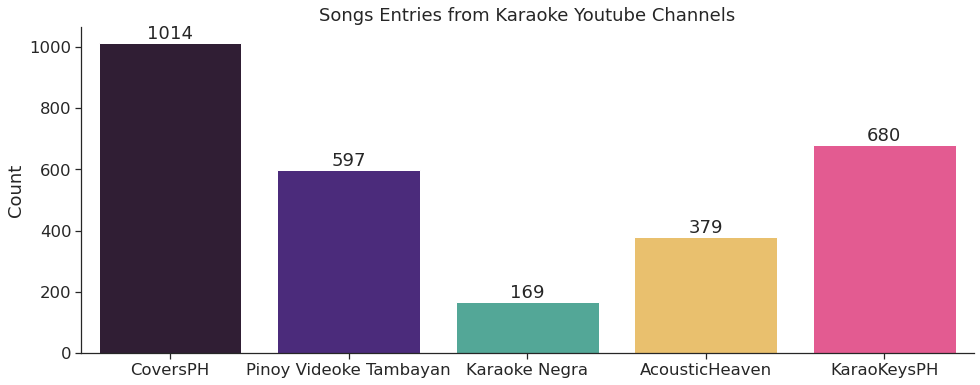

In [58]:
df_karaoke['channelTitle'].value_counts()
ax = sns.countplot(data=df_karaoke, x='channelTitle')
ax.bar_label(ax.containers[0])
ax.set(xlabel='', ylabel='Count')
ax.set_title('Songs Entries from Karaoke Youtube Channels');

<span style="font-size: 18px">
    <b>CoversPH</b> is the most popular channel; <b>KaraoKeysPH</b> is the least popular channel.
</span>

<span style="font-size: 14px">
    In terms of viewership and popularity, uploads from CoversPH takes the number one spot as visually observed from the viewcount histogram of five karaoke youtube channels.
</span>

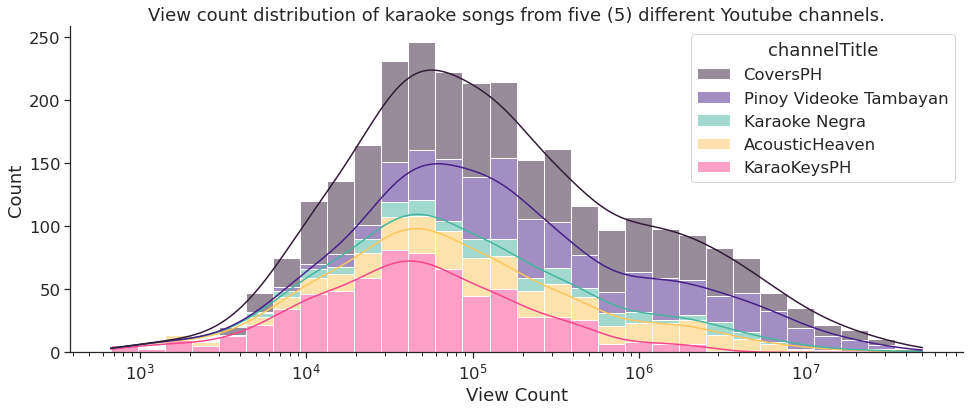

In [59]:
ax = sns.histplot(data=df_karaoke,
             x='viewCount',
             kde=True,
             log_scale=True,
             hue='channelTitle',
             multiple="stack")
 
ax.set(xlabel='View Count', ylabel='Count');
ax.set_title('View count distribution of karaoke songs from five (5) different Youtube channels.');

<span style="font-size: 18px">
    There is a <b>positive association</b> between comments and likes.
</span>

<span style="font-size: 14px">
    Positive association is defined as the tendency of one variable to increase as the other variable increases. This is observed between the like count and comment count from videos across five different karaoke youtube channels.
</span>

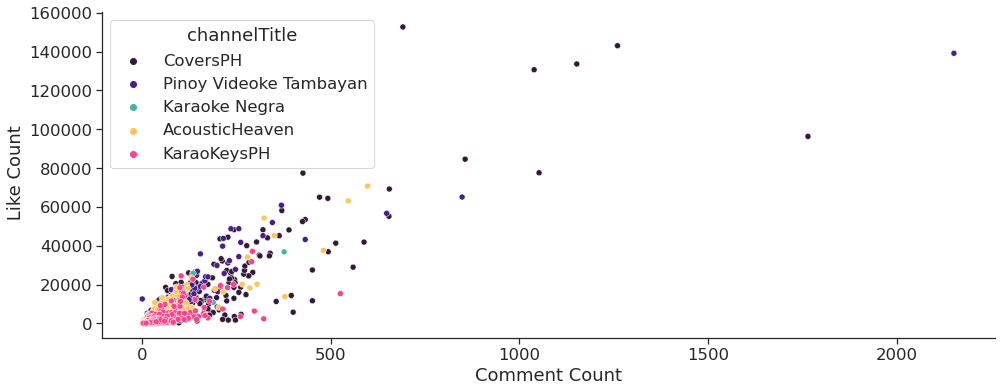

In [60]:
# positive association between comments and likes
ax = sns.scatterplot(data=df_karaoke, x="commentCount", y="likeCount", hue="channelTitle")
ax.set(xlabel='Comment Count', ylabel=' Like Count');
plt.show()

<span style="font-size: 18px">
    Karaoke Youtube channels were consistent in uploading videos from <b>2020 to present</b> (during the pandemic). Highest single day upload count was on <b>February 8, 2019</b> with <b>27</b> video uploads.
</span>

<span style="font-size: 14px">
    Consistency is video uploads can be visually observed by looking for the parts of the plot where the lines are most dense. This is observed from periods 2020 and onwards.
</span>

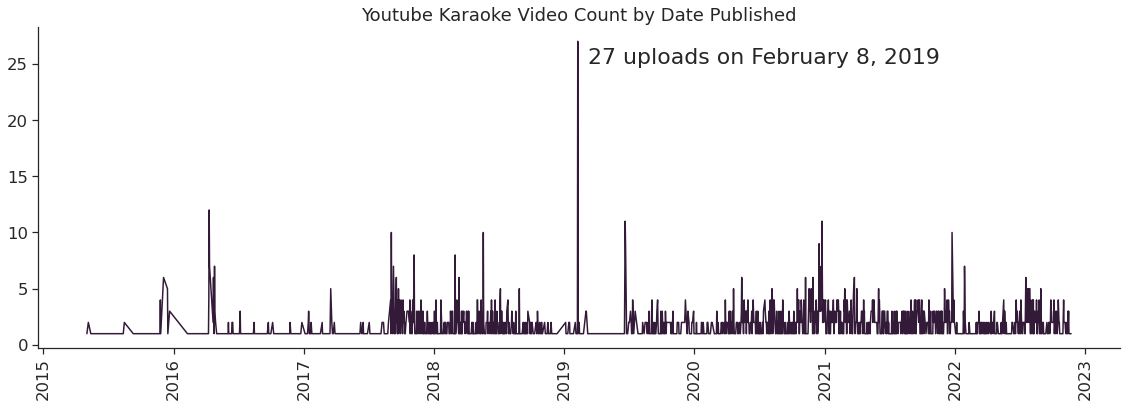

In [61]:
# A lot of songs published in 2019

df_karaoke['date'] = df_karaoke['publishedAt'].dt.date
pop_dates = df_karaoke['date'].value_counts().sort_index()
sns.lineplot(x=pop_dates.index,y=pop_dates.values, data=pop_dates, palette=[colors_2[3]])
plt.xticks(rotation=90)
plt.title('Youtube Karaoke Video Count by Date Published')
plt.tight_layout()
plt.text(datetime.date(2019, 3, 8), 25, '27 uploads on February 8, 2019', fontsize = 22)
plt.show()
# print(df_karaoke['date'].value_counts().head(10))

<span style="font-size: 18px">
    Karaoke Youtube Channels published <b>672</b> videos in <b>2021</b>.
</span>

<span style="font-size: 14px">
    The year 2021 recorded the highest number of video uploads with 672 uploads in 365 days. That's almost two (2) videos a day!
</span>

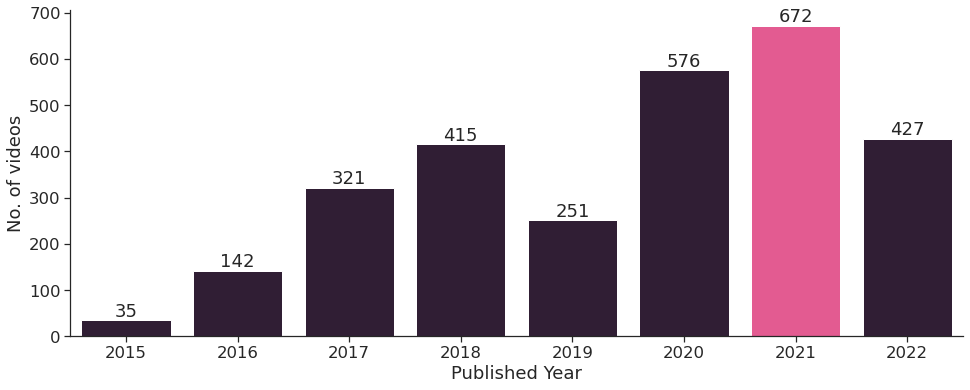

In [62]:
df_karaoke['year'] = df_karaoke['publishedAt'].dt.year
year_pub = df_karaoke["year"].value_counts()\
        .to_frame().reset_index().rename(columns={"index": "year", "year": "No_of_videos"})
fig, ax = plt.subplots()
sns.barplot(x="year", y="No_of_videos", data=year_pub, palette=[colors_2[0]]*6+[colors_2[4]])
ax.set(xlabel="Published Year", ylabel="No. of videos")
#plt.suptitle ("Number of Videos Published by Year")
ax.bar_label(ax.containers[0])
plt.show()
#print(year_pub)

<span style="font-size: 18px">
    Karaoke Youtube channels publishes more videos during <b>ber months</b>.
</span>

<span style="font-size: 14px">
    Ber months is indeed the most wonderful time of the year! Karaoke youtube channels publish the most videos during the fourth quarter.
</span>

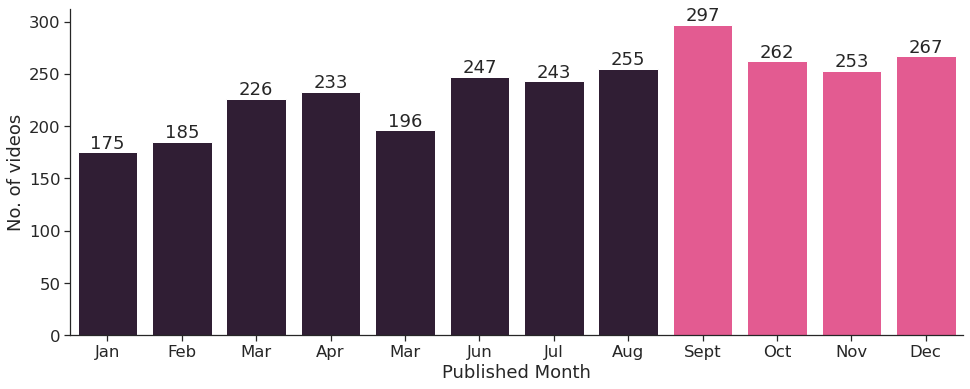

In [63]:
# here i just broke it down further pero oks na actually by year

# monthly vidoes published
df_karaoke['month'] = df_karaoke['publishedAt'].dt.month
month_pub = df_karaoke["month"].value_counts()\
        .to_frame().reset_index().rename(columns={"index": "month", "month": "No_of_videos"})
fig, ax = plt.subplots()
sns.barplot(x="month", y="No_of_videos", data=month_pub, palette=[colors_2[0]]*8+[colors_2[4]]*4)
ax.set(xlabel="Published Month", ylabel="No. of videos")
#plt.suptitle ("Number of Videos Published by Month")
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'Mar', 'Jun',
                    'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
ax.bar_label(ax.containers[0])
plt.show()
#print(month_pub)

<span style="font-size: 18px">
    <b>Having you near me</b>, a song popularized by <b>Air Supply</b>, is the <b>most viewed</b> karaoke song across five channels. Are the other songs familiar?
</span>

<span style="font-size: 14px">
The song Having you near me by the ever popular soft rock duo formed in Melbourne, Victoria, Air Supply, recorded the highest number of views across five karaoke youtube channels. It is likely that you have heard this song at least once in your karaoke sessions.
</span>

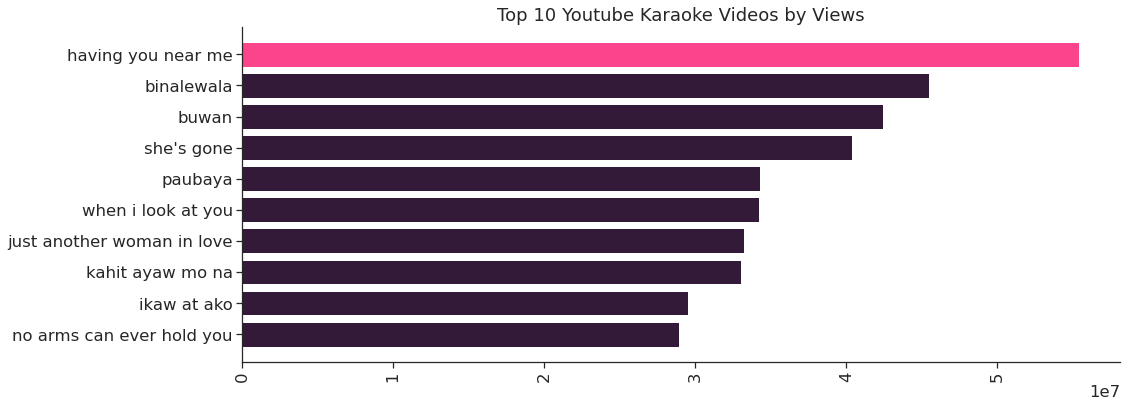

In [64]:
# Can this explain the february topping the month of sing-alongs or singing alone?
song_views = df_karaoke.groupby('song_title').agg(np.sum).sort_values('viewCount',ascending=False).viewCount.head(10).sort_values()

plt.barh(song_views.index, song_views.values, color=[colors_2[0]]*9+[colors_2[4]]*1)
plt.xticks(rotation=90)
plt.title('Top 10 Youtube Karaoke Videos by Views')

plt.tight_layout()
plt.show()

<span style="font-size: 18px">
    <b>Paubaya</b>, a song popularized by <b>Moira Dela Torre</b>, is the <b>most liked</b> karaoke song across five channels. Talk about being haert broken!
</span>

<span style="font-size: 14px">
Paubaya is a song about letting your loved one go. At some point, we have to admit that we're a sucker for sad pensive songs!
</span>

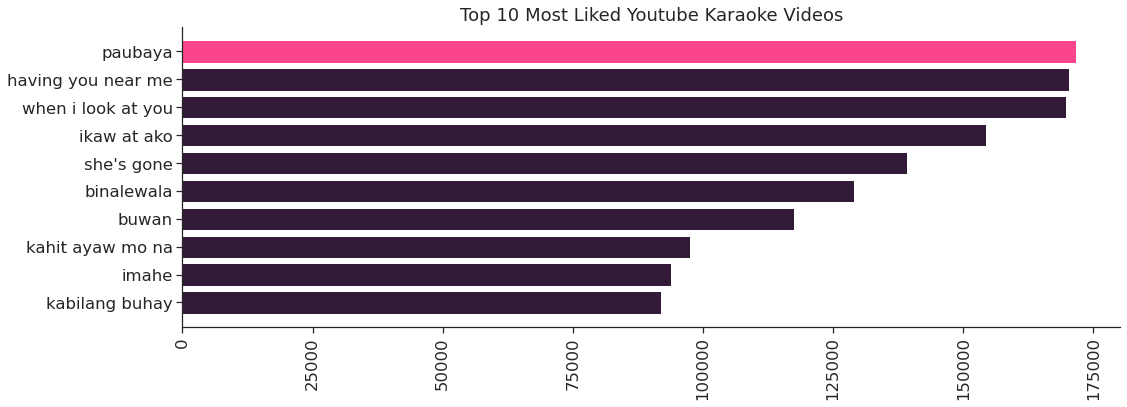

In [65]:
# mukhang madami talaga affected ang pips sa She's Gone by Steelheart
song_likes = df_karaoke.groupby('song_title').agg(np.sum).sort_values('likeCount',ascending=False).likeCount.head(10).sort_values()

plt.barh(song_likes.index, song_likes.values, color=[colors_2[0]]*9+[colors_2[4]]*1)
plt.xticks(rotation=90)
plt.title('Top 10 Most Liked Youtube Karaoke Videos')

plt.tight_layout()
plt.show()

<span style="font-size: 18px">
    <b>Buwan</b>, a song popularized by <b>Juan Karlos</b>, is the <b>most commented</b> karaoke song across five channels. Do you hear your neighbors voice crack at the top of their lungs every night?
</span>

<span style="font-size: 14px">
Juan Karlos is actually a band named after its founding member Juan Karlos Labajo. The band was formed in 2018, and soon released their most popular song "Buwan".
</span>

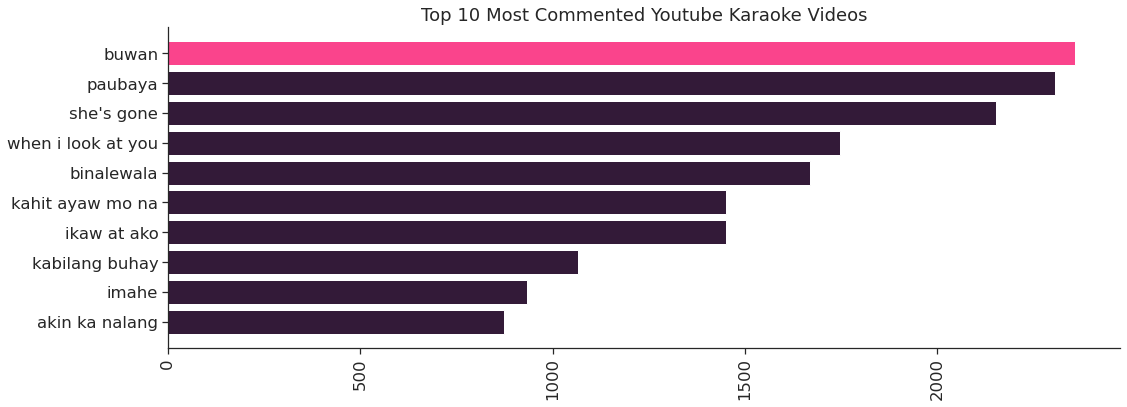

In [66]:
# She's Gone pa din!
song_comments = df_karaoke.groupby('song_title').agg(np.sum).sort_values('commentCount',ascending=False).commentCount.head(10).sort_values()

plt.barh(song_comments.index, song_comments.values, color=[colors_2[0]]*9+[colors_2[4]]*1)
plt.xticks(rotation=90)
plt.title('Top 10 Most Commented Youtube Karaoke Videos')

plt.tight_layout()
plt.show()

<span style="font-size: 18px">
    For all channels, majority of videos with large view counts have song title lengths less than 30 characters.
</span>

<span style="font-size: 14px">
The record for the longest sing title goes to Christine Lavin's single: <i>"Regretting what I said to you when you called me at eleven o'clock on Friday morning to tell me that one o'clock Friday afternoon you were gonna leave your office, go downstairs, hail a cab, to go out to the airport, to catch a plane, to go skiing in the Alps for two weeks. Not that I wanted to go with you; I wasn't able to leave town, I'm not a very good skier, I couldn't expect you to pay my way, but after going out with you for three years, I don't like surprises."</i>. The title does not seem too appealing, which explains why long song title do not translate to large view counts.
</span>



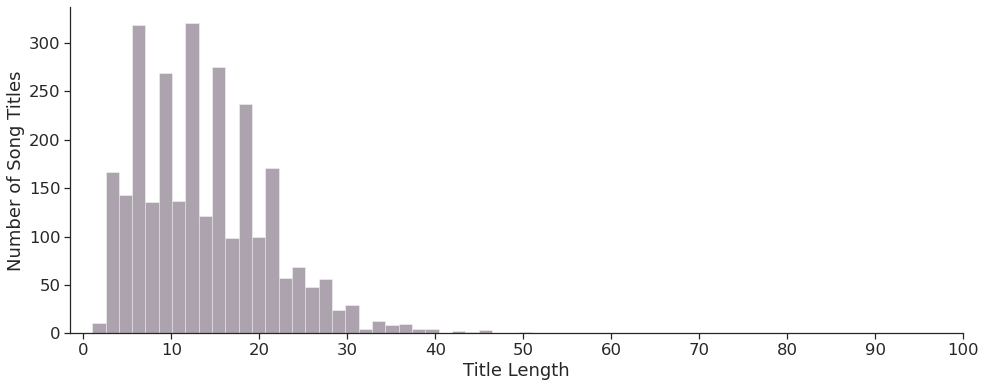

In [67]:
# some text analysis
# getting the title length

df_karaoke["title_length"] = df_karaoke["song_title"].apply(lambda x: len(x))

ax = sns.distplot(df_karaoke["title_length"], kde=False, rug=False)
ax.set(xlabel="Title Length", ylabel="Number of Song Titles", xticks=range(0, 110, 10))
plt.show()

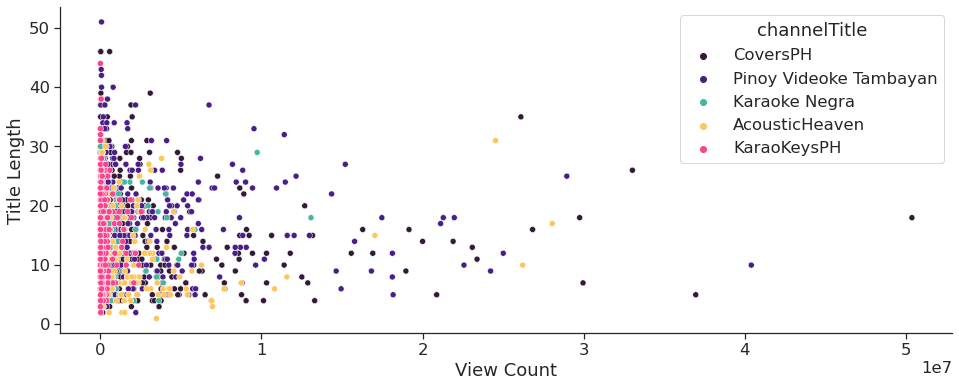

In [68]:
# For all channels, majority of videos with large view counts have song title lengths less than 30
ax = sns.scatterplot(data=df_karaoke, x="viewCount", y="title_length", hue="channelTitle")
ax.set(xlabel="View Count", ylabel="Title Length")
plt.show()

<span style="font-size: 18px">
    The word "<b>Love</b>" is the most common word choice for song titles.
</span>

<span style="font-size: 14px">
Songs that are about love or heartbreak are seen as the most accessible for listeners to relate to through their own personal experiences with love and are therefore easier to market and sell. [4]
</span>

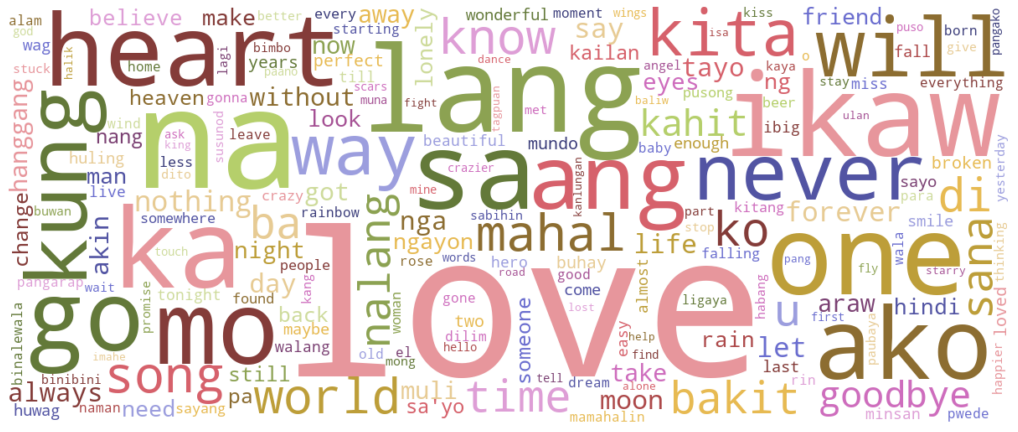

In [69]:
# Most common word
from collections import Counter
import wordcloud
title_words = list(df_karaoke["song_title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(1000)
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(18,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

<span style="font-size: 18px">
    <b>Moira Dela Torre</b> is the most appearing artist in Youtube Karaoke videos.
</span>

<span style="font-size: 14px">
Air Supply is a close second. Regine Velasquez and Sarah Geronimo, both singing reality competition television series judges/mentors came in third and fourth.
</span>

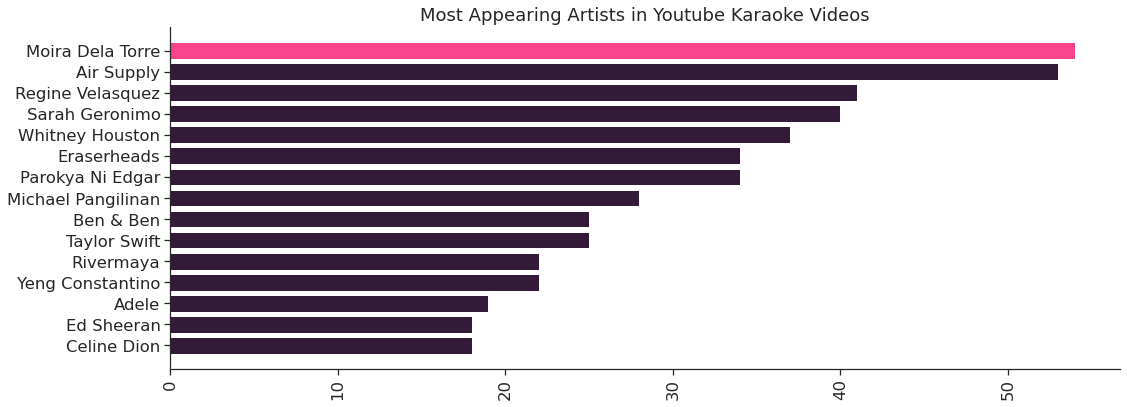

In [70]:
freq_artist = df_karaoke['artist'].str.title().value_counts().nlargest(15).sort_values()

plt.barh(freq_artist.index, freq_artist.values, color=[colors_2[0]]*14+[colors_2[4]]*1)
plt.xticks(rotation=90)
plt.title('Most Appearing Artists in Youtube Karaoke Videos')

plt.tight_layout()
plt.show()

In [71]:
full_df = df_videos.merge(
    df_views.rename(columns={'likeCount':'likeCount_video'}),
    on='videoId').merge(
    df_comments.rename(columns={'likeCount':'likeCount_comment'}),
    on='videoId')

columns = ['channelTitle', 'videoId', 'song_title', 'artist',
           'viewCount', 'likeCount_video', 'commentCount',
           'likeCount_comment', 'textOriginal']
final_df = full_df[columns]
final_df['viewCount'] = final_df['viewCount'].astype(int)
final_df['likeCount_video'] = final_df['likeCount_video'].astype(int)
final_df['commentCount'] = final_df['commentCount'].astype(int)
final_df['likeCount_comment'] = final_df['likeCount_comment'].astype(int)
final_df = final_df.drop_duplicates().reset_index(drop=True)
final_df['commentId'] = range(len(final_df))

ratio_likes_views = final_df.groupby(['channelTitle',
                                      'videoId']).apply(
    lambda x: x['likeCount_video'].mean() / x['viewCount'].mean()
              if x['viewCount'].mean() > 0 else np.nan
)
ratio_comments_likes = final_df.groupby(['channelTitle',
                                         'videoId']).apply(
    lambda x: x['commentCount'].mean() / x['likeCount_video'].mean()
              if x['likeCount_video'].mean() > 0 else np.nan
)
ratio_clikes_likes = pd.Series([e['likeCount_comment'] / e['likeCount_video']
                                if e['likeCount_video'] > 0 else np.nan
                                for i, e in final_df.iterrows()])

<span style="font-size: 18px">
    Distributions of various like like ratios.
</span>

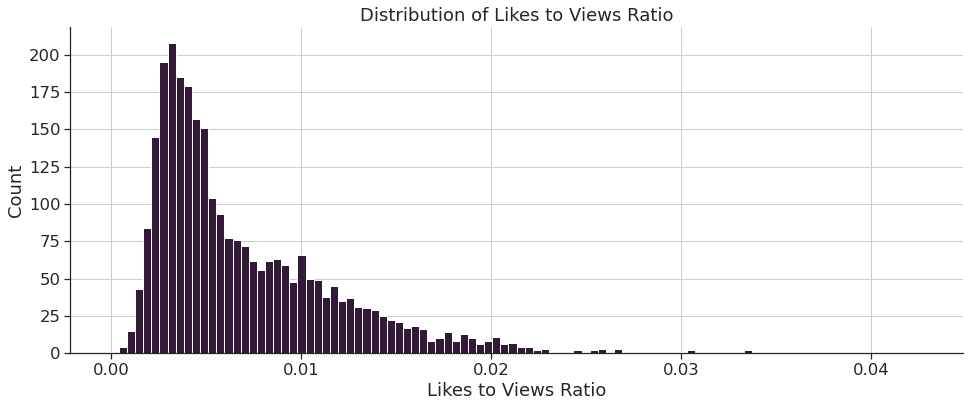

In [72]:
ax = ratio_likes_views.hist(bins=100)
ax.set(xlabel="Likes to Views Ratio", ylabel="Count")
ax.set_title('Distribution of Likes to Views Ratio');

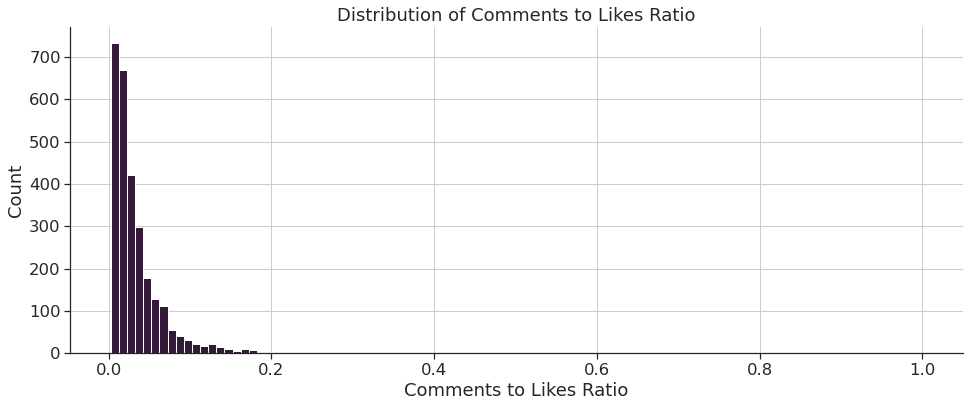

In [73]:
ax = ratio_comments_likes.hist(bins=100);
ax.set(xlabel="Comments to Likes Ratio", ylabel="Count")
ax.set_title('Distribution of Comments to Likes Ratio');

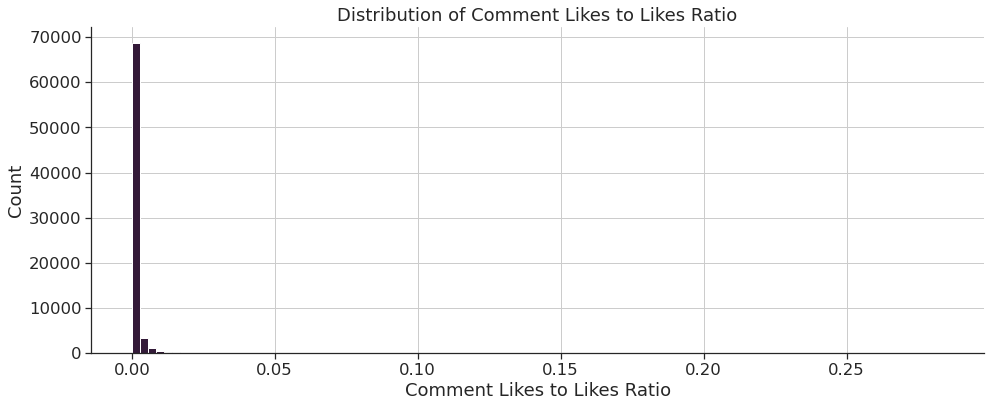

In [74]:
ax = ratio_clikes_likes.hist(bins=100)
ax.set(xlabel="Comment Likes to Likes Ratio", ylabel="Count")
ax.set_title('Distribution of Comment Likes to Likes Ratio');

<h1 style="color:#000000">VI. Methodology</h1>

<center><img src="methodology.png"/></center>

<h1 style="color:#000000">VII. Main Body</h1>

<span style="font-size: 18px">
    Performing Data Vectorization
</span>


This study will utilize TF-IDF, short for term frequency-inverse document frequency, to reflect the importance of a word with respect to a document in a corpus. Unlike Count Vectorizer, that uses bag-of-words representation, the TF-IDF vectorizer utilizes a weighing factor for information retrieval and data mining. 

The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf. [5]

In [75]:
def text_remove_unicode(text):
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return text

def text_remove_stopwords(text, stop):
    text = " ".join([word for word in text.split() if word not in stop])
    return text

def text_line_fixer(phrase):
    stop = stopwords.words('english') + fil_stop_words
    phrase = phrase.lower()
    phrase = text_remove_unicode(phrase)
    phrase = text_remove_stopwords(phrase, stop)
    return phrase

def text_series_fixer(series):
    stop = stopwords.words('english') + fil_stop_words
    series = series.str.lower()
    series = series.apply(text_remove_unicode)
    series = series.apply(lambda x: text_remove_stopwords(x, stop))
    return series

def text_fixer(df):
    new = df.copy()
    for i in new.columns:
        new[i] = text_series_fixer(new[i])
    return new

def text_lower(df):
    new = df.copy()
    for i in new.columns:
        new[i] = new[i].str.lower()
    return new

In [76]:
# title TF-IDF vectorizer

unique_vids = final_df[['videoId',
                        'song_title',
                        'artist',
                        'likeCount_video']].drop_duplicates().reset_index(drop=True)
unique_titles = text_lower(unique_vids[['song_title', 'artist']])

clean_titles = text_series_fixer(unique_titles['song_title'])

titles_vec = TfidfVectorizer()
titles_vec.fit(clean_titles)
T = titles_vec.transform(clean_titles)
titles_tfidf = pd.DataFrame(T.toarray(),
                            columns=titles_vec.get_feature_names_out())
print(f'Shape: {titles_tfidf.shape}')
titles_tfidf.head()

Shape: (2812, 1238)


,10,12,1251,20,2020,21,214,241,25,aaminin,...,yakap,years,yellow,yesterday,youll,young,youre,youve,zebbiana,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
all_df = final_df[['videoId', 'song_title', 'artist',
                   'textOriginal', 'likeCount_comment']]
mean_likes = all_df['likeCount_comment'].mean()
# print(f'{mean_likes}')
all_df = all_df[all_df['likeCount_comment'] >= mean_likes]

In [78]:
mean_likes

2.6133092329979664

To get more context from the words, we combined the song title and the comments related to that song. However, we only considered considered comments with likes greater than or equal to the average number of likes. In this case, the average number of likes is 2.61, hence we only considered comments with three (3) or more likes.

After data vectorization, we ended up with a dataframe compoased of 1,838 rows and 26,888 columns. Obviously, working with 26,888 would not be an ideal setup as it will require huge amount of time to render the results. One way to bypass this problem is by dimensionality reduction.

In [79]:
all_df = all_df.groupby('videoId').apply(
    lambda x: ' '.join(x['song_title'] + ' ' + x['textOriginal'].tolist())
).reset_index(name='text')
all_df = all_df.merge(final_df[['videoId',
                                'song_title',
                                'artist',
                                'likeCount_video']].drop_duplicates(),
                      how='left')
unique_titles_all = text_lower(all_df[['song_title', 'artist']])

clean_text = text_series_fixer(all_df['text'])

all_vec = TfidfVectorizer()
all_vec.fit(clean_text)
A = all_vec.transform(clean_text)
all_tfidf = pd.DataFrame(A.toarray(),
                         columns=all_vec.get_feature_names_out())
print(all_tfidf.shape)
all_tfidf.head()

(1838, 26888)


,000027,0007,001005,0016,0019,006,007,008,009,010,...,zoopaalam,zsazsa,zu,zucker,zum,zuniga,zutto,zutto3rd,zuttomune,zuttoprechorussou
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<span style="font-size: 18px">
    Performing Dimensionality Reduction
</span>

Since we still want to retain a significant amount of information, we decided to set the variance explained threshold at 90%. By performaning dimensionality reduction through Principal Component Analysis, we managed to reduce the number of columns from 26,888 columns to 1,104 while still retaining 90% of information.

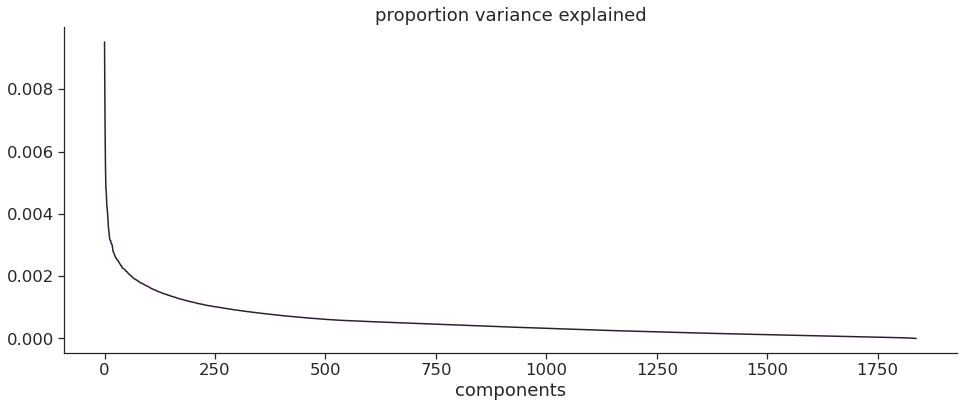

In [80]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(all_tfidf)

plt.plot(range(len(all_tfidf)), pca.explained_variance_ratio_)
plt.xlabel('components')
plt.title('proportion variance explained');

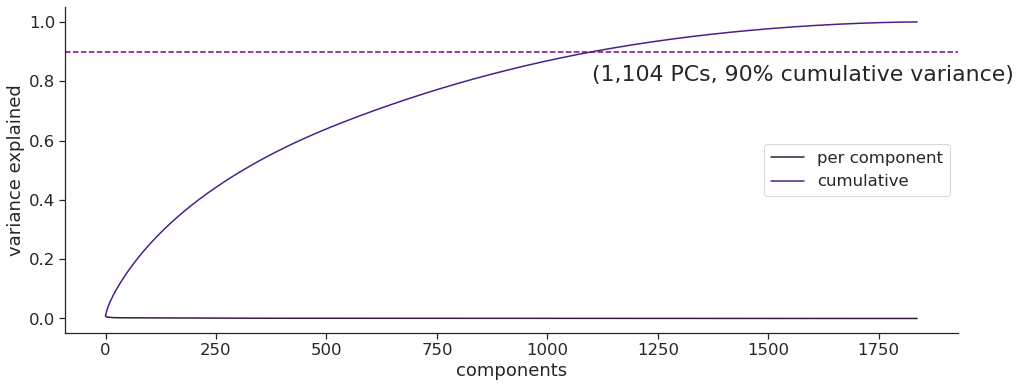

In [83]:
plt.plot(range(len(all_tfidf)), pca.explained_variance_ratio_, label='per component')

cumulative = pca.explained_variance_ratio_.cumsum()
ninety = np.argmax(cumulative>=0.9) + 1
plt.plot(range(len(all_tfidf)), cumulative, label='cumulative')
plt.axhline(cumulative[ninety-1], ls='--', c='purple')

plt.text(1100, 0.8, '(1,104 PCs, 90% cumulative variance)', fontsize = 22)
plt.xlabel('components')
plt.ylabel('variance explained')
plt.legend();

In [84]:
pca = PCA(n_components=ninety, svd_solver='full')
pca.fit(all_tfidf)
# print(pca.explained_variance_ratio_.sum())
new_all_tfidf = pca.transform(all_tfidf)
# print(new_all_tfidf.shape)

<span style="font-size: 18px">
    Clustering
</span>

Since we are handling unlabeled data, we will use `k means` clustering to determine the clusters based on similarities `k`. By pre-determining `n_clusters` = 5, we were able to group our data into clusters of comparable spatial extent as illustrated by the different color groupings.

We were also able to find a strong correlation between the feature `love` and the principals components. Despite the utilization of an unsupervised model, we were still able to match songs which are closely related to `love`.

In [85]:
from sklearn.cluster import KMeans

n_clusters = 5
Kmean = KMeans(n_clusters=n_clusters,
               random_state=1251)
Kmean.fit(new_all_tfidf)
with_labels = unique_titles_all.copy()
with_labels['labels'] = Kmean.labels_

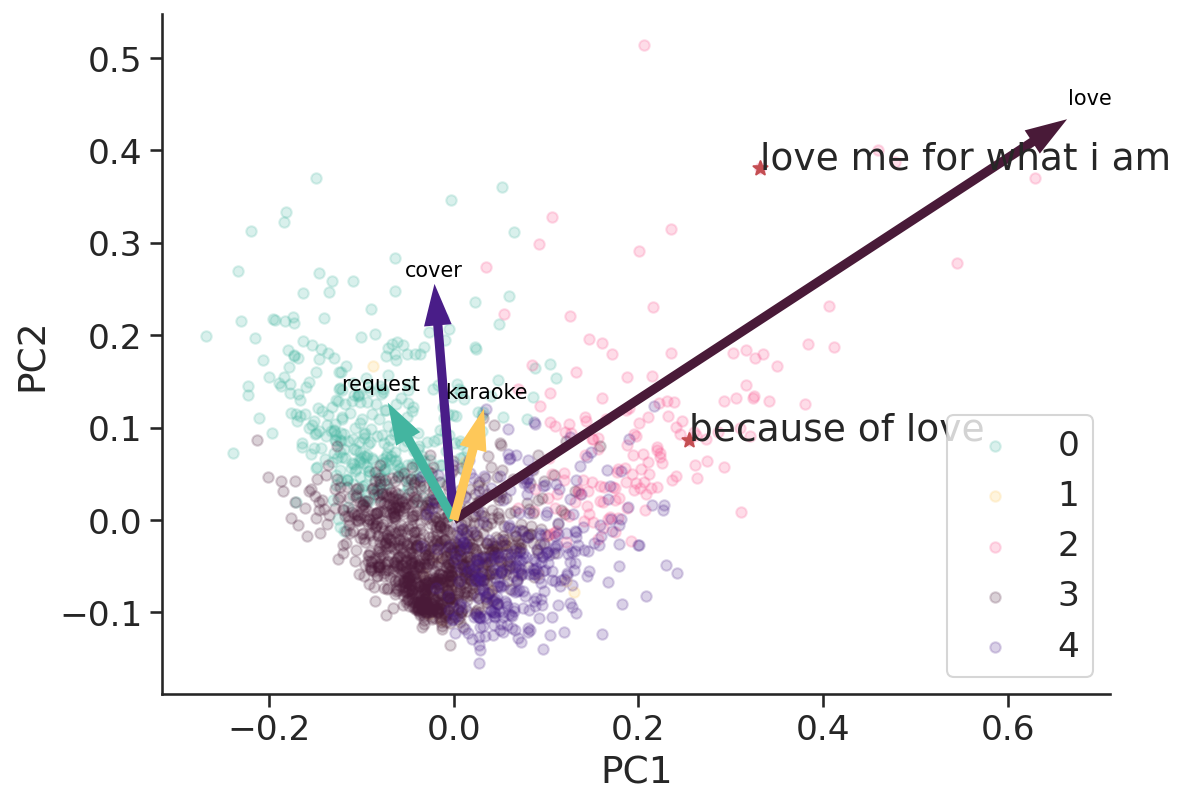

In [86]:
colors = ['#491a38', '#491d88', '#43b5a0', '#fec859', '#fa508c']

fig, ax = plt.subplots(1, 1, subplot_kw=dict(aspect='equal'), dpi=150)
for i in range(n_clusters):
    ax.scatter(new_all_tfidf[ np.where(Kmean.labels_ == i) , 0],
               new_all_tfidf[ np.where(Kmean.labels_ == i) , 1],
               label=i,
               c=colors[(i+2)%len(colors)],
               alpha=0.2,
               s=25)
mark_idx = [66, 29]
mark = new_all_tfidf[mark_idx, :2]
ax.scatter(mark[:, 0], mark[:, 1], c='r', marker='*', s=50)
for i, e in enumerate(mark_idx):
    ax.text(mark[i, 0], mark[i, 1],
            with_labels.iloc[e]['song_title'])
ax.legend()

features = all_tfidf.columns
w = pca.components_.T
words = ['love', 'cover', 'request', 'karaoke']
mult = [1.1, 1.25, 1.6, 1.7]
idx = [features.tolist().index(i) for i in words]
vecs = w[idx]

for i, m in enumerate(words):
    ax.arrow(0, 0, vecs[i, 0], vecs[i, 1],
             width=0.01, ec='none', fc=colors[i])
    ax.text(mult[i]*vecs[i, 0], mult[i]*vecs[i, 1],
            m, ha='center', color='black', size=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

In [95]:
with_labels = unique_titles_all.copy()
with_labels['labels'] = Kmean.labels_
# with_labels[ with_labels['labels'] == 2 ]

Below, we plotted the first five most important principal components and their strongest features arranged from strongest to weakest. In the first principal component, the word `love` topped the list followed by the word `song`.

The word `po` on the otherhand, ranked third despite the word possible qualifying as a Filipino stopword. However, this can be interpreted as the culture of "respect" in Filipinos especially when addressing elders. This culture of respect is also evident in the digital space.

For karaoke youtube channels, the common theme of the comments section is song requests. These song requests are usually accompanied by the word po whenever a song is being requested.

Example commnets:
- Pa request naman po ng Magda by Marko Rudio. 🙏
- Can i use this po for cover ?
- Pahiram po ng instrumental for cover! Tnx

The word `po` extends to the second principal component where it ranked as the strongest feature. The feature is also present in other principal components.

Some notable words:
- song
- cover
- sana

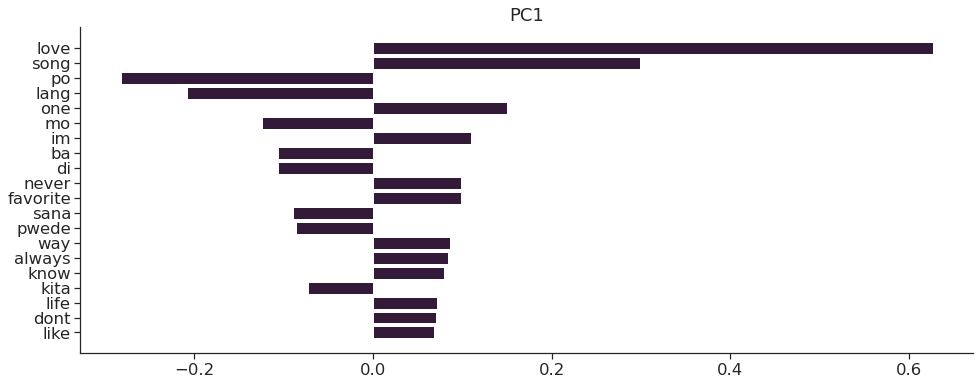

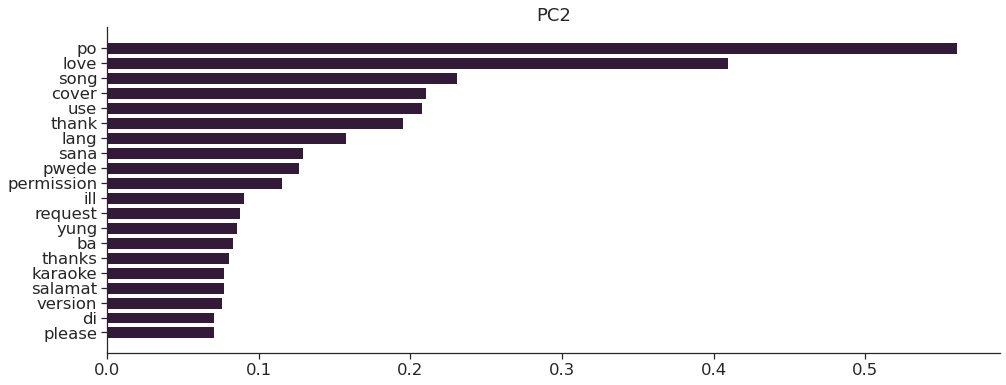

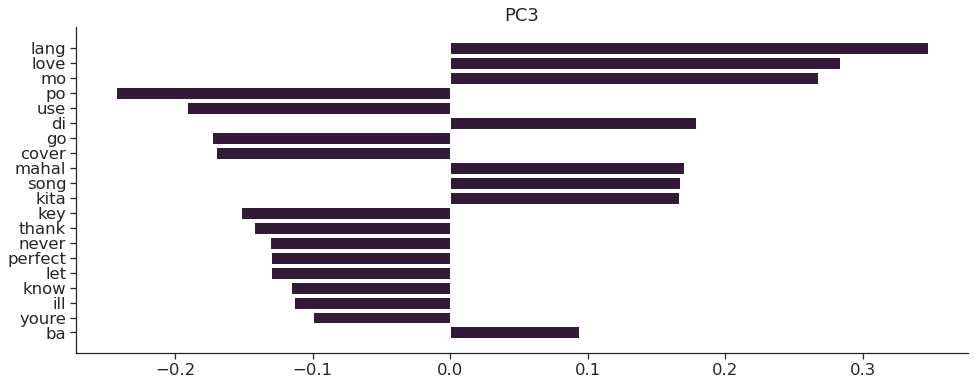

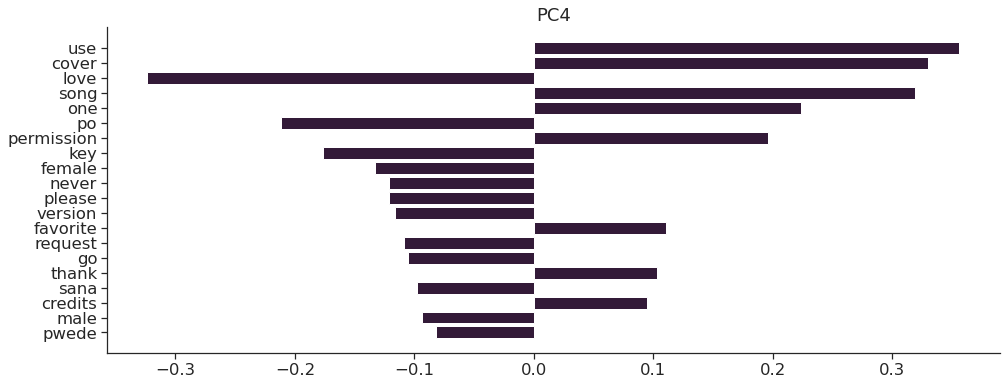

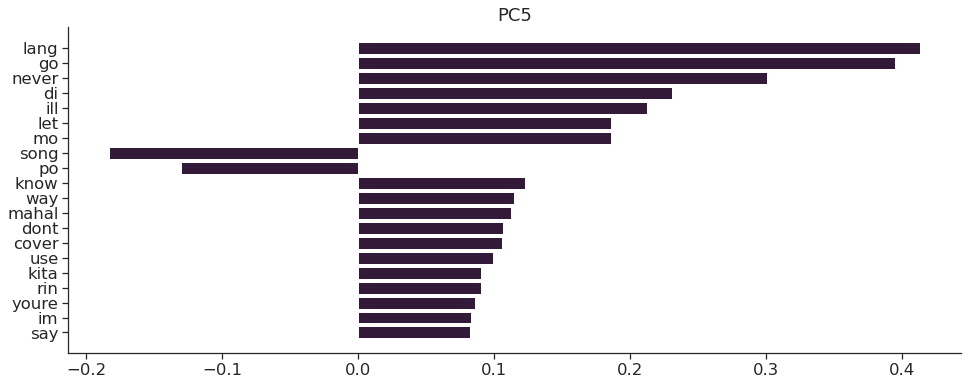

In [88]:
for i in range(5):
    fig, ax = plt.subplots()
    order = np.argsort(np.abs(w[:, i]))[-20:]
    ax.barh([features[o] for o in order], w[order, i])
    ax.set_title(f'PC{i+1}')

<span style="font-size: 18px">
    Song Recommender Engine
</span>

This song recommender engine recommends songs according to a user's preference and creates a list of the top five songs that are similar to the user's song of query. Below are some sample queries using the recommender engine.

In [89]:
def recommend_song(similar=None, describe=None, recommend=5):
    
    if not describe:
        chosen = unique_vids[['likeCount_video']].copy()
        if not similar:
            chosen = chosen.sort_values(
                'likeCount_video',
                ascending=False
            )
            close = unique_titles.iloc[chosen.index.values]
        else:
            similar = [text_line_fixer(similar)]
            q = titles_vec.transform(similar)
            q = dict.fromkeys(titles_tfidf.columns, 0) 
            for i in similar:
                if i in q.keys():
                    q[i] += 1
            q = pd.DataFrame(q, index=[0])

            result = {}
            for i, e in titles_tfidf.iterrows():
                result[i] = cosine_distances(q,
                                             np.asarray(e).reshape(1, -1))[0][0]
            dists = pd.Series(result)

            chosen['dist'] = dists
            chosen = chosen.sort_values(
                ['dist', 'likeCount_video'],
                ascending=[True, False]
            )
            close = unique_titles.iloc[chosen.index.values]
    else:
        if not similar:
            similar = describe
        else:
            raise ValueError('Can you give a title, or describe a song yourself?')
        
        similar = [text_line_fixer(similar)]
        q = all_vec.transform(similar)
        q = dict.fromkeys(all_tfidf.columns, 0) 
        for i in similar:
            if i in q.keys():
                q[i] += 1
        q = pd.DataFrame(q, index=[0])
        new_q = pca.transform(q)
        
        result = {}
        for i, e in enumerate(new_all_tfidf):
            result[i] = cosine_distances(new_q,
                                         e.reshape(1, -1))[0][0]
        dists = pd.Series(result)

        chosen = all_df[['likeCount_video']].copy()
        chosen['dist'] = dists
        chosen = chosen.sort_values(
            ['dist', 'likeCount_video'],
            ascending=[True, False]
        )
        close = unique_titles_all.iloc[chosen.index.values]
        
    return close.drop_duplicates().reset_index(drop=True)[:recommend]

<span style="font-size: 18px">
    Sample Default Query
</span>

Here are the top five (5) results of the `default` sample search query.

In [90]:
recommend_song()

,song_title,artist
0,having you near me,air supply
1,paubaya,moira dela torre
2,she's gone,steelheart
3,ikaw at ako,moira & jason
4,when i look at you,miley cyrus


<span style="font-size: 18px">
    Sample song title query
</span>

Here are the top five (5) results of a search query that looks through the `song_title` column for the keyword `i love you`.

In [91]:
recommend_song(similar="rain")

,song_title,artist
0,it will rain,bruno mars
1,rain,sarah geronimo
2,through the rain,mariah carey
3,come in out of the rain,sheryn regis
4,walking in the rain,a1


Here are the top five (5) results of a search query that looks through the `song_title` column for the keyword `moment`.

In [92]:
recommend_song(similar="moment")

,song_title,artist
0,from this moment,shania twain
1,one moment in time,whitney houston
2,how does a moment last forever,celine dion
3,love theme from st. elmo's fire (for just a mo...,david foster
4,having you near me,air supply


<span style="font-size: 18px">
    Sample song description query
</span>

Here are the top five (5) results of a search query that looks through the combined `song_title` and `comments` columns for the keyword `sad`.

In [93]:
recommend_song(describe="sad")

,song_title,artist
0,it's sad to belong,england dan & john ford coley
1,i started a joke,beegees
2,find me,david gates
3,till there was you,the beatles
4,everything i own,bread


Here are the top five (5) results of a search query that looks through the combined `song_title` and `comments` columns for the keyword `i am very happy`.

In [94]:
recommend_song(describe="i am very happy")

,song_title,artist
0,hello,adele
1,maybe,neocolours
2,the past,ray parker
3,happy breakup,donnalyn bartolome
4,iingatan ka,carol banawa


<h1 style="color:#000000">VIII. Results and Discussion</h1>

<span style="font-size: 20px"><b>Why we use cosine similarity instead of $L_p$-norm?</b><p>&nbsp; </p> </span>

<b>$L_p$-norm</b> is basically the distance between two vectors or points. The $L_p$-norm between two vectors $\vec v_1$ and $\vec v_2$ is
$$L_p(\vec v_1, \vec v_2) = \left(\sum_i \left| \vec v_{1_i} - \vec v_{2_i} \right|^p \right)^{1/p}$$

If $p=2$, it is the usual Euclidean distance. If $p=1$, it is known as the city block or Manhattan distance.

On the other hand, the **cosine similarity** between two vectors is related to the angle between them. The cosine similarity between two vectors $\vec v_1$ and $\vec v_2$ is
$$S_\text{cos}(\vec v_1, \vec v_2) = \frac{\vec v_1 \cdot \vec v_2}{\left|\left|\vec v_1\right|\right| \left|\left| \vec v_2 \right|\right|}.$$


If the vectors are nonnegative, which is the case for BoW vectors, its range is $[0,1]$ with 1 implying the two vectors are aligned (most similar) and 0 implying they are perpendicular (least similar).

The cosine similarity is beneficial because even if the two similar data objects are far apart by the Euclidean distance because of the size, they could still have a smaller angle between them. Smaller the angle, higher the similarity.

For recommender systems, one of the most commonly used similarity measures is cosine similarity.

<span style="font-size: 20px"><b>Which is better? Count Vectorizer or TF-IDF Vectorizer?</b></span>

TF-IDF is in general better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.
    


<span style="font-size: 20px"><b>Does our Filipino stopwords include all Filipino words??</b></span>

No. One of the limitations of this project is the limited availability of Filipino stop words. The filipino stop words module that the project used only contains less than 150 Filipino stop words.
    


<h1 style="color:#000000">IX. Conclusion</h1>

The project was able to answer the problem statement by utilizing a combination of TF-IDF Vectorization, PCA Dimensionality Reduction, and K Means Clustering methodologies. 

We were able to identify a strong correlation between the feature `love` and the principal components. In fact, by using the unsupervised models of k means clustering, we were still able to match songs which are closely related to `love`.

However, working with a lot a constraints such as the Filipino stop words limitations, unavailability of a genre specification, lack of sentiment analysis, we were not able to fully grasp the semantics of the features.

<h1 style="color:#000000">X. Recommendation</h1>

One way to improve the project is by having a target feature such as genre so that we gauge the accuracy of our information retrieval methodogy as well as create other exploratory tools such as confusion matrix.

To take the project to a whole new level, we can match the userID of the comments to their respective geolocations, so we can identify the all time favorite songs of each region of the country.


<h1 style="color:#000000">XI. References</h1>

[1] Schwartz, BL. (Sep 1999). <a id="ref2" href="https://link.springer.com/article/10.3758/BF03210827.">"Sparkling at the end of the tongue: the etiology of tip-of-the-tongue phenomenology". </a> Psychonomic Bulletin & Review. 6 (3): 379–93. doi:10.3758/bf03210827. PMID 12198776.
 
[2] Brown, Roger; McNeill, David (1966). <a id="ref2" href="https://www.sciencedirect.com/science/article/abs/pii/S0022537166800403?via%3Dihub.">"The "tip of the tongue" phenomenon". </a> Journal of Verbal Learning and Verbal Behavior. 5 (4): 325–337. doi:10.1016/S0022-5371(66)80040-3.
 
[3] Rastle, Kathleen G.; Burke, Deborah M. (1996). <a id="ref2" href="https://www.sciencedirect.com/science/article/abs/pii/S0749596X96900315?via%3Dihub.">"Priming the Tip of the Tongue: Effects of Prior Processing on Word Retrieval in Young and Older Adults". </a> Journal of Memory and Language. 35 (4): 586–605. doi:10.1006/jmla.1996.0031. S2CID 13884102.

[4] Oliver Picken. (2022, Feb 20). <a id="ref2" href="https://www.theedgesusu.co.uk/records/2022/02/20/why-are-pop-songs-so-obsessed-with-love/."> Why Are Pop Songs So Obsessed With Love?</a> The Edge: The University of Southampton's entertainment magazine.

[5] Breitinger, Corinna; Gipp, Bela; Langer, Stefan (2015-07-26). <a id="ref2" href="https://link.springer.com/article/10.1007/s00799-015-0156-0.">"Research-paper recommender systems : a literature survey"</a> <i>International Journal on Digital Libraries. 17 (4): 305–338.</i> doi:10.1007/s00799-015-0156-0. ISSN 1432-5012 S2CID 207035184

